# Homework 2: Desperately Seeking Silver

Due Thursday, Oct 3, 11:59 PM

<center>
<img src="http://www.scribewise.com/Portals/202647/images/photo.jpg">
</center>
<br>

In HW1, we explored how to make predictions (with uncertainties) about upcoming elections based on the Real Clear Politics poll. This assignment also focuses on election prediction, but we are going to implement and evaluate a number of more sophisticated forecasting techniques. 

We are going to focus on the 2012 Presidential election. Analysts like Nate Silver, Drew Linzer, and Sam Wang developed highly accurate models that correctly forecasted most or all of the election outcomes in each of the 50 states. We will explore how hard it is to recreate similarly successful models. The goals of this assignment are:

1. To practice data manipulation with Pandas
1. To develop intuition about the interplay of **precision**, **accuracy**, and **bias** when making predictions
1. To better understand how election forecasts are constructed

The data for our analysis will come from demographic and polling data. We will simulate building our model on October 2, 2012 -- approximately one month before the election. 

### Instructions

The questions in this assignment are numbered. The questions are also usually italicised, to help you find them in the flow of this notebook. At some points you will be asked to write functions to carry out certain tasks. Its worth reading a little ahead to see how the function whose body you will fill in will be used.

**This is a long homework. Please do not wait until the last minute to start it!**

The data for this homework can be found at [this link](https://www.dropbox.com/s/vng5x10b837ahnc/hw2_data.zip). Download it to the same folder where you are running this notebook, and uncompress it. You should find the following files there:

1. us-states.json
2. electoral_votes.csv
3. predictwise.csv
4. g12.csv
5. g08.csv
6. 2008results.csv
7. nat.csv
8. p04.csv
9. 2012results.csv
10. cleaned-state_data2012.csv

#### Setup and Plotting code

In [2]:
%matplotlib inline
from collections import defaultdict
import json

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl
import seaborn as sns

#colorbrewer2 Dark2 qualitative color table
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'white'
rcParams['patch.facecolor'] = dark2_colors[0]
rcParams['font.family'] = 'StixGeneral'


def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecesasry plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()
        
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

/Users/alexanderbaker/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:800: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


In [3]:
#this mapping between states and abbreviations will come in handy later
states_abbrev = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

Here is some code to plot [State Chloropleth](http://en.wikipedia.org/wiki/Choropleth_map) maps in matplotlib. `make_map` is the function you will use.

In [4]:
#adapted from  https://github.com/dataiap/dataiap/blob/master/resources/util/map_util.py

#load in state geometry
state2poly = defaultdict(list)

data = json.load(open("hw2_data/us-states.json"))
for f in data['features']:
    state = states_abbrev[f['id']]
    geo = f['geometry']
    if geo['type'] == 'Polygon':
        for coords in geo['coordinates']:
            state2poly[state].append(coords)
    elif geo['type'] == 'MultiPolygon':
        for polygon in geo['coordinates']:
            state2poly[state].extend(polygon)

            
def draw_state(plot, stateid, **kwargs):
    """
    draw_state(plot, stateid, color=..., **kwargs)
    
    Automatically draws a filled shape representing the state in
    subplot.
    The color keyword argument specifies the fill color.  It accepts keyword
    arguments that plot() accepts
    """
    for polygon in state2poly[stateid]:
        xs, ys = zip(*polygon)
        plot.fill(xs, ys, **kwargs)

        
def make_map(states, label):
    """
    Draw a cloropleth map, that maps data onto the United States
    
    Inputs
    -------
    states : Column of a DataFrame
        The value for each state, to display on a map
    label : str
        Label of the color bar

    Returns
    --------
    The map
    """
    fig = plt.figure(figsize=(12, 9))
    ax = plt.gca()

    if states.max() < 2: # colormap for election probabilities 
        cmap = cm.RdBu
        vmin, vmax = 0, 1
    else:  # colormap for electoral votes
        cmap = cm.binary
        vmin, vmax = 0, states.max()
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    
    skip = set(['National', 'District of Columbia', 'Guam', 'Puerto Rico',
                'Virgin Islands', 'American Samoa', 'Northern Mariana Islands'])
    for state in states_abbrev.values():
        if state in skip:
            continue
        color = cmap(norm(states.ix[state]))
        draw_state(ax, state, color = color, ec='k')

    #add an inset colorbar
    ax1 = fig.add_axes([0.45, 0.70, 0.4, 0.02])    
    cb1=mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                  norm=norm,
                                  orientation='horizontal')
    ax1.set_title(label)
    remove_border(ax, left=False, bottom=False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-180, -60)
    ax.set_ylim(15, 75)
    return ax

## Today: the day we make the prediction

In [5]:
# We are pretending to build our model 1 month before the election
import datetime
today = datetime.datetime(2012, 10, 2)
today

datetime.datetime(2012, 10, 2, 0, 0)

## Background: The Electoral College

US Presidential elections revolve around the <a href="http://en.wikipedia.org/wiki/Electoral_College_(United_States)"> Electoral College </a>. In this system, each state receives a number of Electoral College votes depending on it's population -- there are 538 votes in total. In most states, all of the electoral college votes are awarded to the presidential candidate who recieves the most votes in that state. A candidate needs 269 votes to be elected President. 

Thus, to calculate the total number of votes a candidate gets in the election, we add the electoral college votes in the states that he or she wins. (This is not entirely true, with Nebraska and Maine splitting their electoral college votes, but, for the purposes of this homework, we shall assume that the winner of the most votes in Maine and Nebraska gets ALL the electoral college votes there.) 

Here is the electoral vote breakdown by state:

*As a matter of convention, we will index all our dataframes by the state name*

In [6]:
electoral_votes = pd.read_csv("hw2_data/electoral_votes.csv").set_index('State')
electoral_votes.head()

,Votes
State,
California,55
Texas,38
New York,29
Florida,29
Illinois,20


To illustrate the use of `make_map` we plot the Electoral College

/Users/alexanderbaker/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


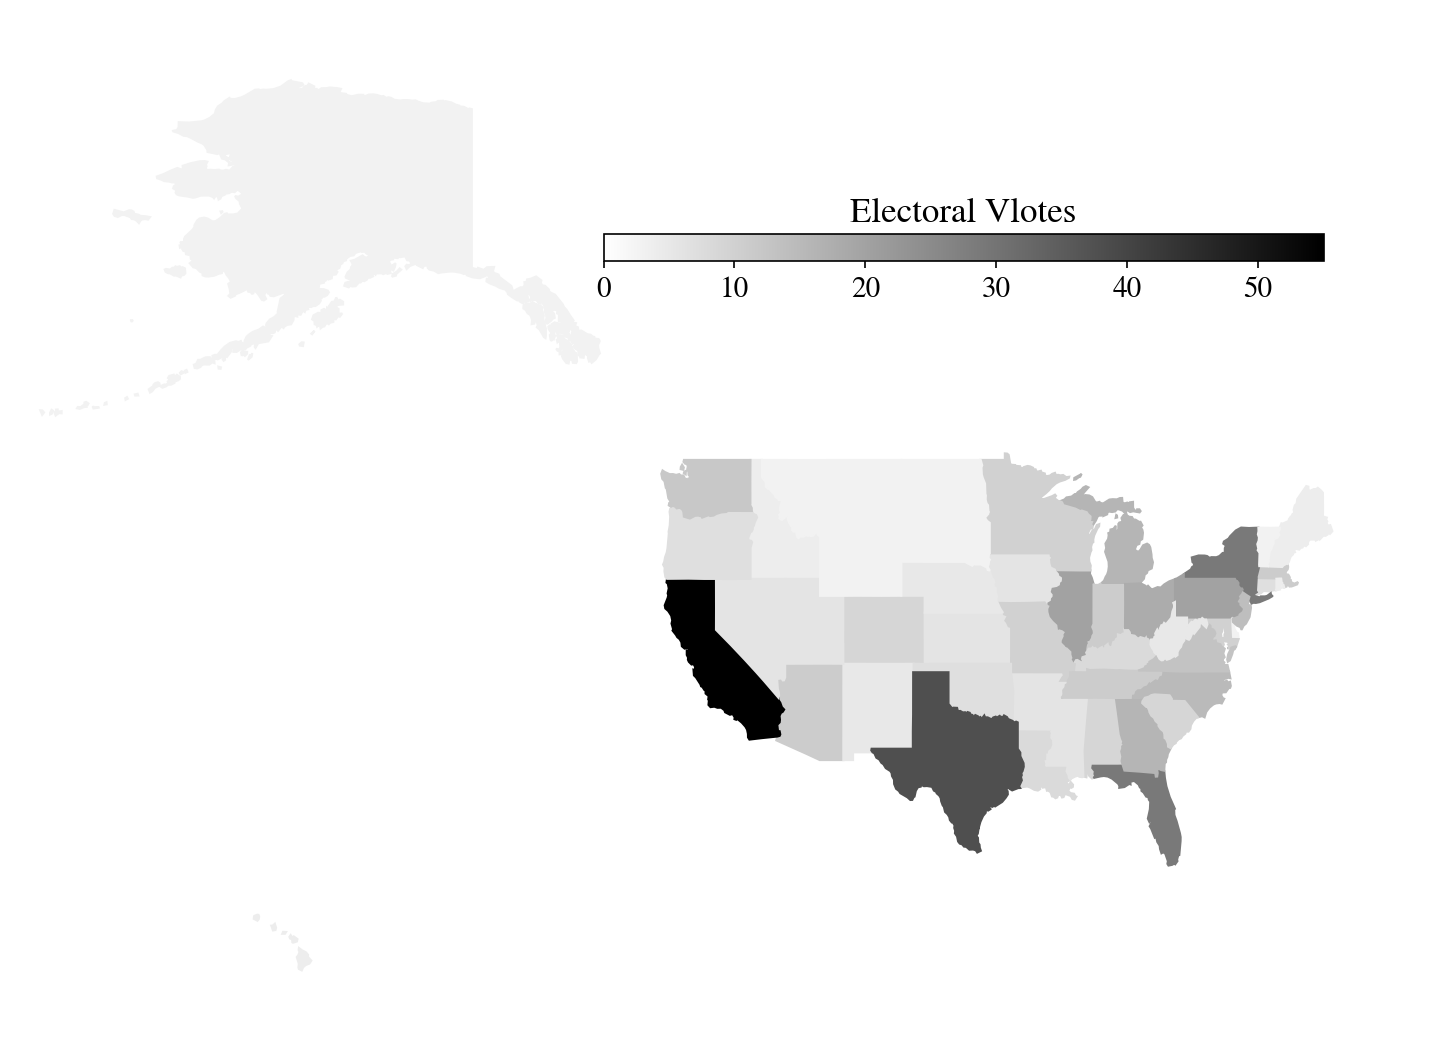

In [7]:
make_map(electoral_votes.Votes, "Electoral Vlotes");

## Question 1: Simulating elections

#### The PredictWise Baseline

We will start by examining a successful forecast that [PredictWise](http://www.predictwise.com/results/2012/president) made on October 2, 2012. This will give us a point of comparison for our own forecast models.

PredictWise aggregated polling data and, for each state, estimated the probability that the Obama or Romney would win. Here are those estimated probabilities:

In [8]:
predictwise = pd.read_csv('hw2_data/predictwise.csv').set_index('States')
predictwise.head()

,Obama,Romney,Votes
States,,,
Alabama,0.000,1.000,9
Alaska,0.000,1.000,3
Arizona,0.062,0.938,11
Arkansas,0.000,1.000,6
California,1.000,0.000,55


**1.1** Each row is the probability predicted by Predictwise that Romney or Obama would win a state. The votes column lists the number of electoral college votes in that state. *Use `make_map` to plot a map of the probability that Obama wins each state, according to this prediction*.

/Users/alexanderbaker/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


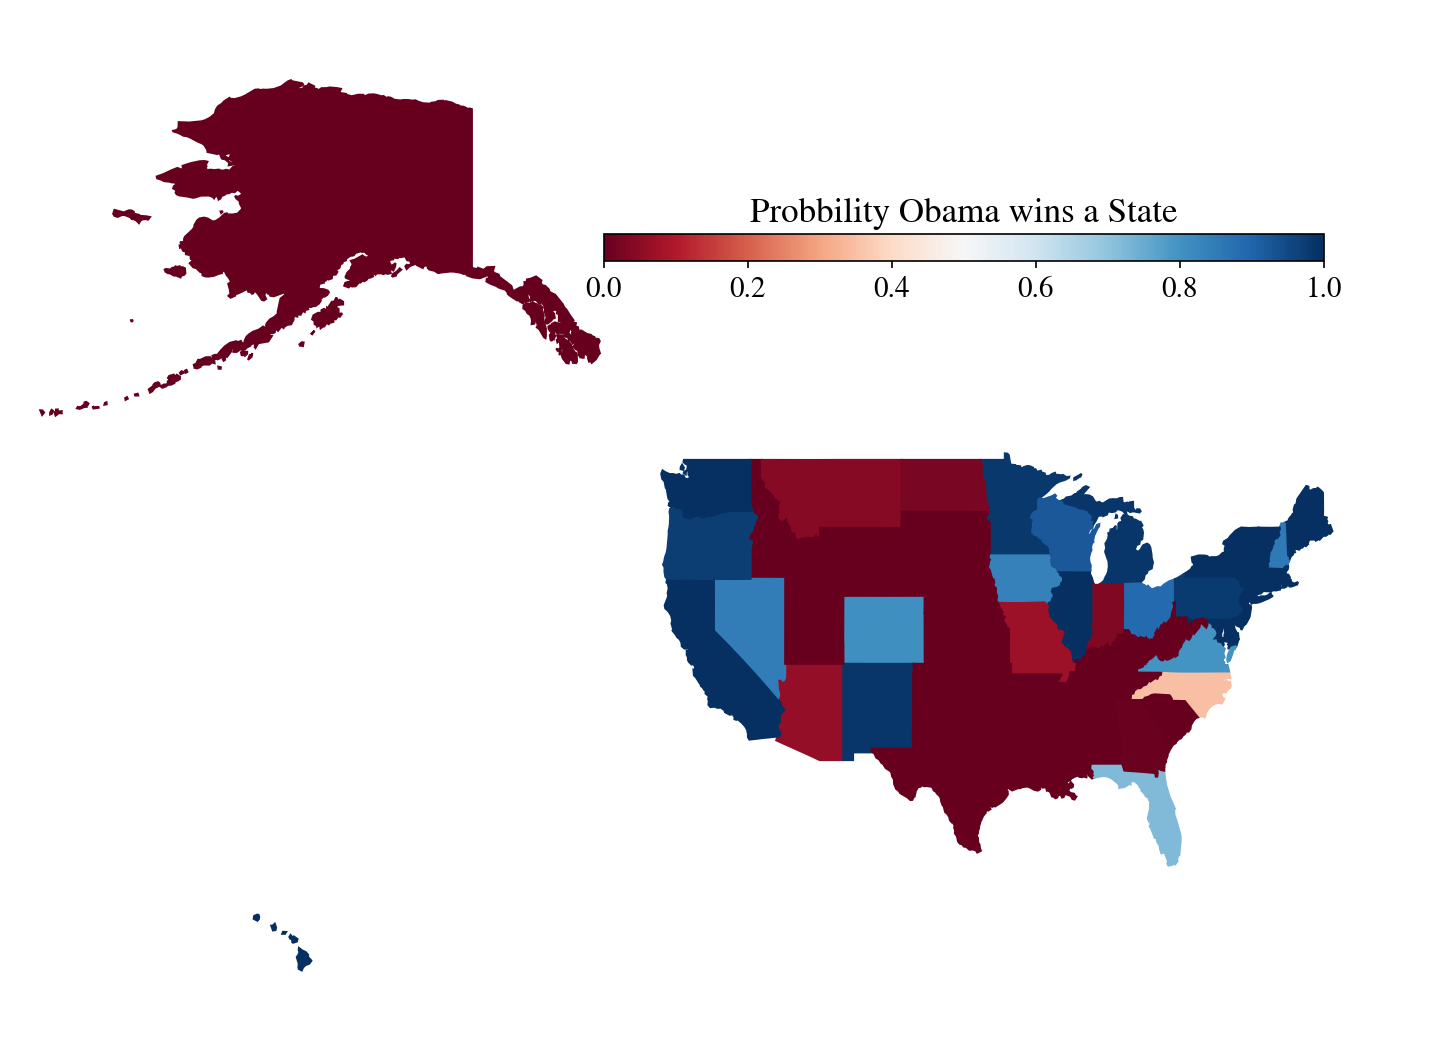

In [9]:
#your code here
make_map(predictwise.Obama, "Probbility Obama wins a State");

Later on in this homework we will explore some approaches to estimating probabilities like these and quatifying our uncertainty about them. But for the time being, we will focus on how to make a prediction assuming these probabilities are known.

Even when we assume the win probabilities in each state are known, there is still uncertainty left in the election. We will use simulations from a simple probabilistic model to characterize this uncertainty. From these simulations, we will be able to make a prediction about the expected outcome of the election, and make a statement about how sure we are about it.

**1.2** We will assume that the outcome in each state is the result of an independent coin flip whose probability of coming up Obama is given by a Dataframe of state-wise win probabilities. *Write a function that uses this **predictive model** to simulate the outcome of the election given a Dataframe of probabilities*.

In [10]:
def simulate_election(model, n_sim):
    """
    Function
    --------
    simulate_election

    Inputs
    ------
    model : DataFrame
        A DataFrame summarizing an election forecast. The dataframe has 51 rows -- one for each state and DC
        It has the following columns:
           Obama : Forecasted probability that Obama wins the state
           Votes : Electoral votes for the state
        The DataFrame is indexed by state (i.e., model.index is an array of state names)

    n_sim : int
       Number of simulations to run

    Returns
    -------
    results : Numpy array with n_sim elements
       Each element stores the number of electoral college votes Obama wins in each simulation.   
    """
    #Your code here
    simulations = np.random.uniform(size=(51, n_sim))
    obama_votes = (simulations < model.Obama.values.reshape(-1, 1)) * model.Votes.values.reshape(-1, 1)
    return obama_votes.sum(axis=0)


The following cells takes the necessary DataFrame for the Predictwise data, and runs 10000 simulations. We use the results to compute the probability, according to this predictive model, that Obama wins the election (i.e., the probability that he receives 269 or more electoral college votes)

In [11]:
result = simulate_election(predictwise, 10000)

In [12]:
#compute the probability of an Obama win, given this simulation
#Your code here
print ("In our simulation Obama won:", (result >= 269).sum(), "out of 10000")

In our simulation Obama won: 9947 out of 10000


**1.3** **Now, write a function called `plot_simulation` to visualize the simulation**. This function should:

* Build a histogram from the result of simulate_election
* Overplot the "victory threshold" of 269 votes as a vertical black line (hint: use axvline)
* Overplot the result (Obama winning 332 votes) as a vertical red line
* Compute the number of votes at the 5th and 95th quantiles, and display the difference (this is an estimate of the outcome's uncertainty)
* Display the probability of an Obama victory    
    

In [13]:
#your code here
def plot_simulation(simulation): 
    """
        Function
        --------
        plot_simulation

        Inputs
        ------
        simulation: Numpy array with n_sim (see simulate_election) elements
           Each element stores the number of electoral college votes Obama wins in each simulation.

        Returns
        -------
        Nothing 
    """
    plt.hist(simulation, bins=np.arange(200, 538, 1), 
             label='simulations', align='left', normed=True)
    plt.axvline(332, 0, .5, color='r', label='Actual Outcome')
    plt.axvline(269, 0, .5, color='k', label='Victory Threshold')
    p05 = np.percentile(simulation, 5.)
    p95 = np.percentile(simulation, 95.)
    iq = int(p95 - p05)
    pwin = ((simulation >= 269).mean() * 100)
    plt.title("Chance of Obama Victory: %0.2f%%, Spread: %d votes" % (pwin, iq))
    plt.legend(frameon=False, loc='upper left')
    plt.xlabel("Obama Electoral College Votes")
    plt.ylabel("Probability")
    sns.despine()
    plt.show()
    plt.clf()

Lets plot the result of the Predictwise simulation. Your plot should look something like this:

<img src="http://i.imgur.com/uCOFXHp.png">

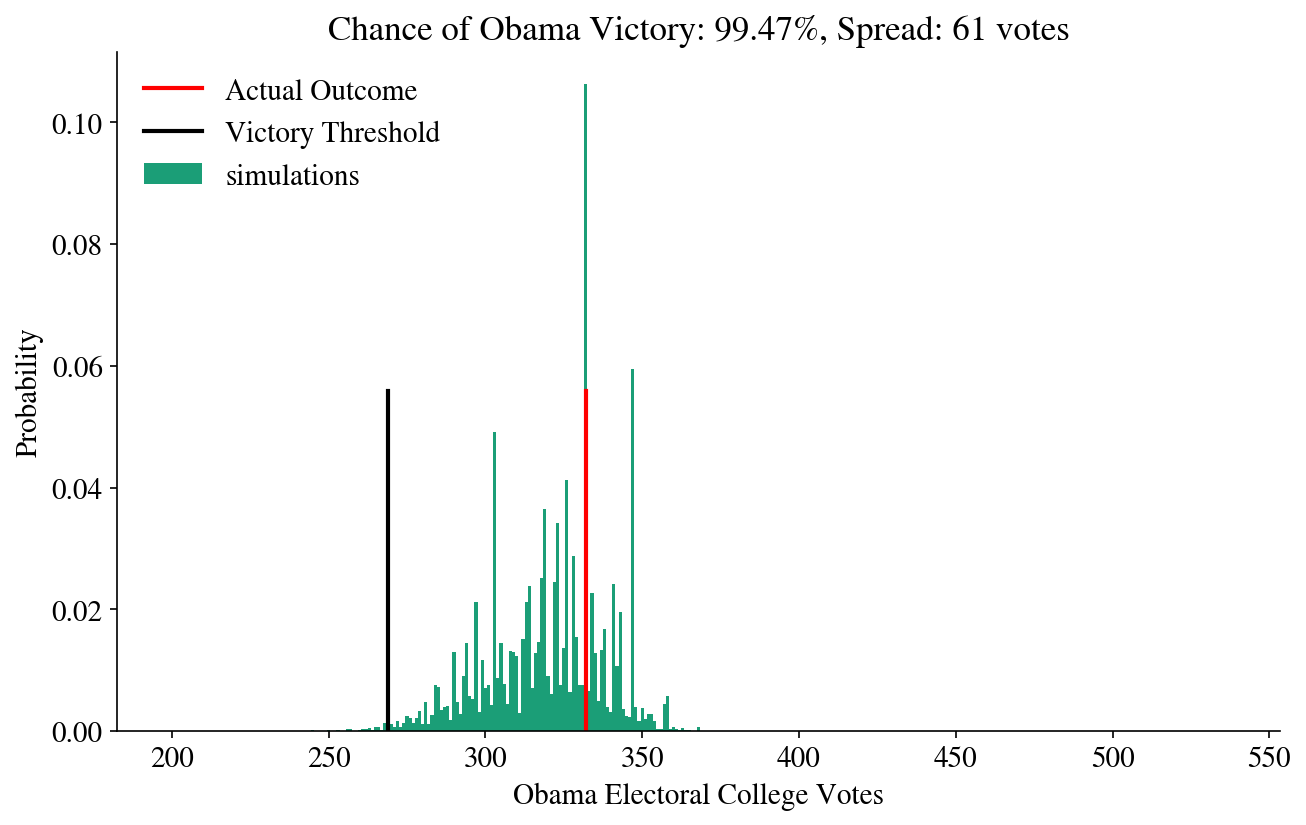

In [14]:
plot_simulation(result)

#### Evaluating and Validating our Forecast

The point of creating a probabilistic predictive model is to simultaneously make a forecast and give an estimate of how certain we are about it. 

However, in order to trust our prediction or our reported level of uncertainty, the model needs to be *correct*. We say a model is *correct* if it honestly accounts for all of the mechanisms of variation in the system we're forecasting.

In this section, we **evaluate** our prediction to get a sense of how useful it is, and we **validate** the predictive model by comparing it to real data.

**1.4** Suppose that we believe the model is correct. Under this assumption, we can **evaluate** our prediction by characterizing its **accuracy** and **precision** (see [here](http://celebrating200years.noaa.gov/magazine/tct/accuracy_vs_precision_556.jpg) for an illustration of these ideas). *What does the above plot reveal about the **accuracy** and **precision** of the PredictWise model?*

It appears our model is mostly accurate though i am not entirely sure if it's precise. I would argue it's extremely precise because the probability distribution is spread across 100 electoral votes.

**1.5** Unfortunately, we can never be *absolutely sure* that a model is correct, just as we can never be absolutely sure that the sun will rise tomorrow. But we can test a model by making predictions assuming that it is true and comparing it to real events -- this constitutes a hypothesis test. After testing a large number of predictions, if we find no evidence that says the model is wrong, we can have some degree of confidence that the model is right (the same reason we're still quite confident about the sun being here tomorrow). We call this process **model checking**, and use it to **validate** our model.

*Describe how the graph provides one way of checking whether the prediction model is correct. How many predictions have we checked in this case? How could we increase our confidence in the model's correctness?*

The graph generated above is a way of checking the model correctness by allowing use to visualize the prediction distribution of the model. By visualizing the distribution we can get a sense in what the model will predict generally speaking. 

The amount of predictions were checking with is roughly 10000 simulations. Though these are not real events they at least provide us with some way of experimenting.

One way could improve our confidence in our model is if we utilized more datasets when constructing our model.

### Gallup Party Affiliation Poll

Now we will try to **estimate** our own win probabilities to plug into our predictive model.

We will start with a simple forecast model. We will try to predict the outcome of the election based the estimated proportion of people in each state who identify with one one political party or the other.

Gallup measures the political leaning of each state, based on asking random people which party they identify or affiliate with. [Here's the data](http://www.gallup.com/poll/156437/heavily-democratic-states-concentrated-east.aspx#2) they collected from January-June of 2012:

In [15]:
gallup_2012=pd.read_csv("hw2_data/g12.csv").set_index('State')
gallup_2012["Unknown"] = 100 - gallup_2012.Democrat - gallup_2012.Republican
gallup_2012.head()

,Democrat,Republican,Dem_Adv,N,Unknown
State,,,,,
Alabama,36.0,49.6,-13.6,3197,14.4
Alaska,35.9,44.3,-8.4,402,19.8
Arizona,39.8,47.3,-7.5,4325,12.9
Arkansas,41.5,40.8,0.7,2071,17.7
California,48.3,34.6,13.7,16197,17.1


Each row lists a state, the percent of surveyed individuals who identify as Democrat/Republican, the percent whose identification is unknown or who haven't made an affiliation yet, the margin between Democrats and Republicans (`Dem_Adv`: the percentage identifying as Democrats minus the percentage identifying as Republicans), and the number `N` of people surveyed.

**1.6** This survey can be used to predict the outcome of each State's election. The simplest forecast model assigns 100% probability that the state will vote for the majority party.  *Implement this simple forecast*.

In [16]:
def simple_gallup_model(gallup):    
    """
        Function
        --------
        simple_gallup_model

        A simple forecast that predicts an Obama (Democratic) victory with
        0 or 100% probability, depending on whether a state
        leans Republican or Democrat.

        Inputs
        ------
        gallup : DataFrame
            The Gallup dataframe above

        Returns
        -------
        model : DataFrame
            A dataframe with the following column
             * Obama: probability that the state votes for Obama. All values should be 0 or 1
            model.index should be set to gallup.index (that is, it should be indexed by state name)

        Examples
        ---------
        >>> simple_gallup_model(gallup_2012).ix['Florida']
        Obama    1
        Name: Florida, dtype: float64
        >>> simple_gallup_model(gallup_2012).ix['Arizona']
        Obama    0
        Name: Arizona, dtype: float64
    """
def simple_gallup_model(gallup):
    return pd.DataFrame(dict(Obama=(gallup.Dem_Adv > 0).astype(float)))

Now, we run the simulation with this model, and plot it.

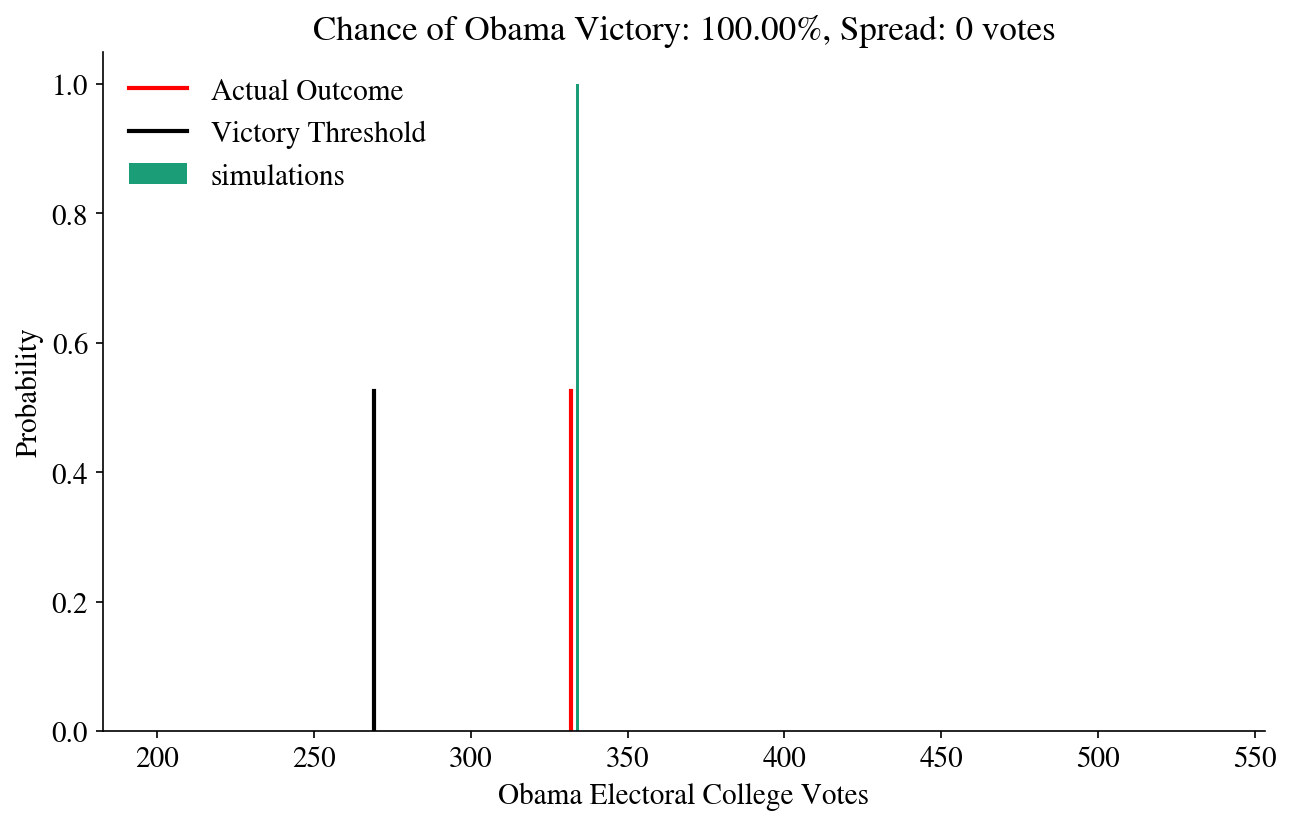

/Users/alexanderbaker/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


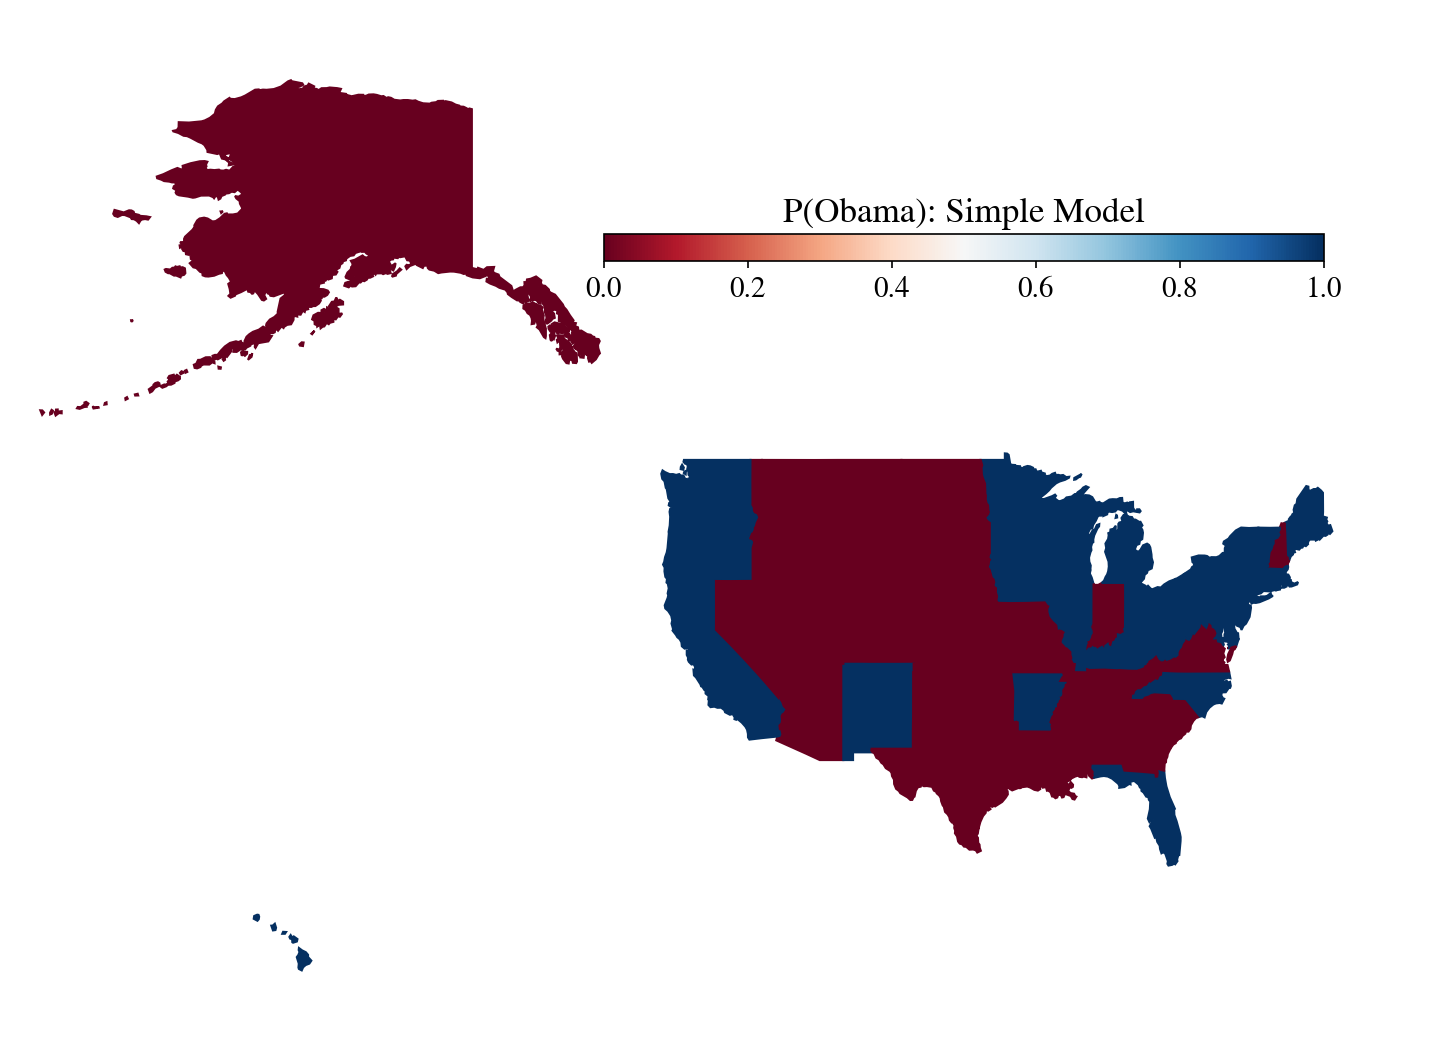

In [17]:
model = simple_gallup_model(gallup_2012)
model = model.join(electoral_votes)
prediction = simulate_election(model, 10000)

plot_simulation(prediction)
plt.show()
make_map(model.Obama, "P(Obama): Simple Model")

**1.7** Attempt to **validate** the predictive model using the above simulation histogram. *Does the evidence contradict the predictive model?*

The evidence shows that while the model was accurate and precise. It over fitted the data and handle no variances and can't handle uncertainity. As seen with the model predictions being all found at rought 380 electoral college votes. 

#### Adding Polling Uncertainty to the Predictive Model

The model above is brittle -- it includes no accounting for uncertainty, and thus makes predictions with 100% confidence. This is clearly wrong -- there are numerous sources of uncertainty in estimating election outcomes from a poll of affiliations. 

The most obvious source of error in the Gallup data is the finite sample size -- Gallup did not poll *everybody* in America, and thus the party affilitions are subject to sampling errors. How much uncertainty does this introduce?

On their [webpage](http://www.gallup.com/poll/156437/heavily-democratic-states-concentrated-east.aspx#2) discussing these data, Gallup notes that the sampling error for the states is between 3 and 6%, with it being 3% for most states. (The calculation of the sampling error itself is an exercise in statistics. Its fun to think of how you could arrive at the sampling error if it was not given to you. One way to do it would be to assume this was a two-choice situation and use binomial sampling error for the non-unknown answers, and further model the error for those who answered 'Unknown'.)

**1.8** Use Gallup's estimate of 3% to build a Gallup model with some uncertainty. Assume that the `Dem_Adv` column represents the mean of a Gaussian, whose standard deviation is 3%. Build the model in the function `uncertain_gallup_model`. *Return a forecast where the probability of an Obama victory is given by the probability that a sample from the `Dem_Adv` Gaussian is positive.*


**Hint**
The probability that a sample from a Gaussian with mean $\mu$ and standard deviation $\sigma$ exceeds a threhold $z$ can be found using the the Cumulative Distribution Function of a Gaussian:

$$
CDF(z) = \frac1{2}\left(1 + {\rm erf}\left(\frac{z - \mu}{\sqrt{2 \sigma^2}}\right)\right) 
$$


In [21]:
"""
Function
--------
uncertain_gallup_model

A forecast that predicts an Obama (Democratic) victory if the random variable drawn
from a Gaussian with mean Dem_Adv and standard deviation 3% is >0

Inputs
------
gallup : DataFrame
    The Gallup dataframe above

Returns
-------
model : DataFrame
    A dataframe with the following column
     * Obama: probability that the state votes for Obama.
    model.index should be set to gallup.index (that is, it should be indexed by state name)
"""
# your code here
from scipy.special import erf
def uncertain_gallup_model(gallup):
    sigma = 3
    prob =  .5 * (1 + erf(gallup.Dem_Adv / np.sqrt(2 * sigma**2)))
    return pd.DataFrame(dict(Obama=prob), index=gallup.index)

We construct the model by estimating the probabilities:

In [22]:
model = uncertain_gallup_model(gallup_2012)
model = model.join(electoral_votes)

Once again, we plot a map of these probabilities, run the simulation, and display the results

/Users/alexanderbaker/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


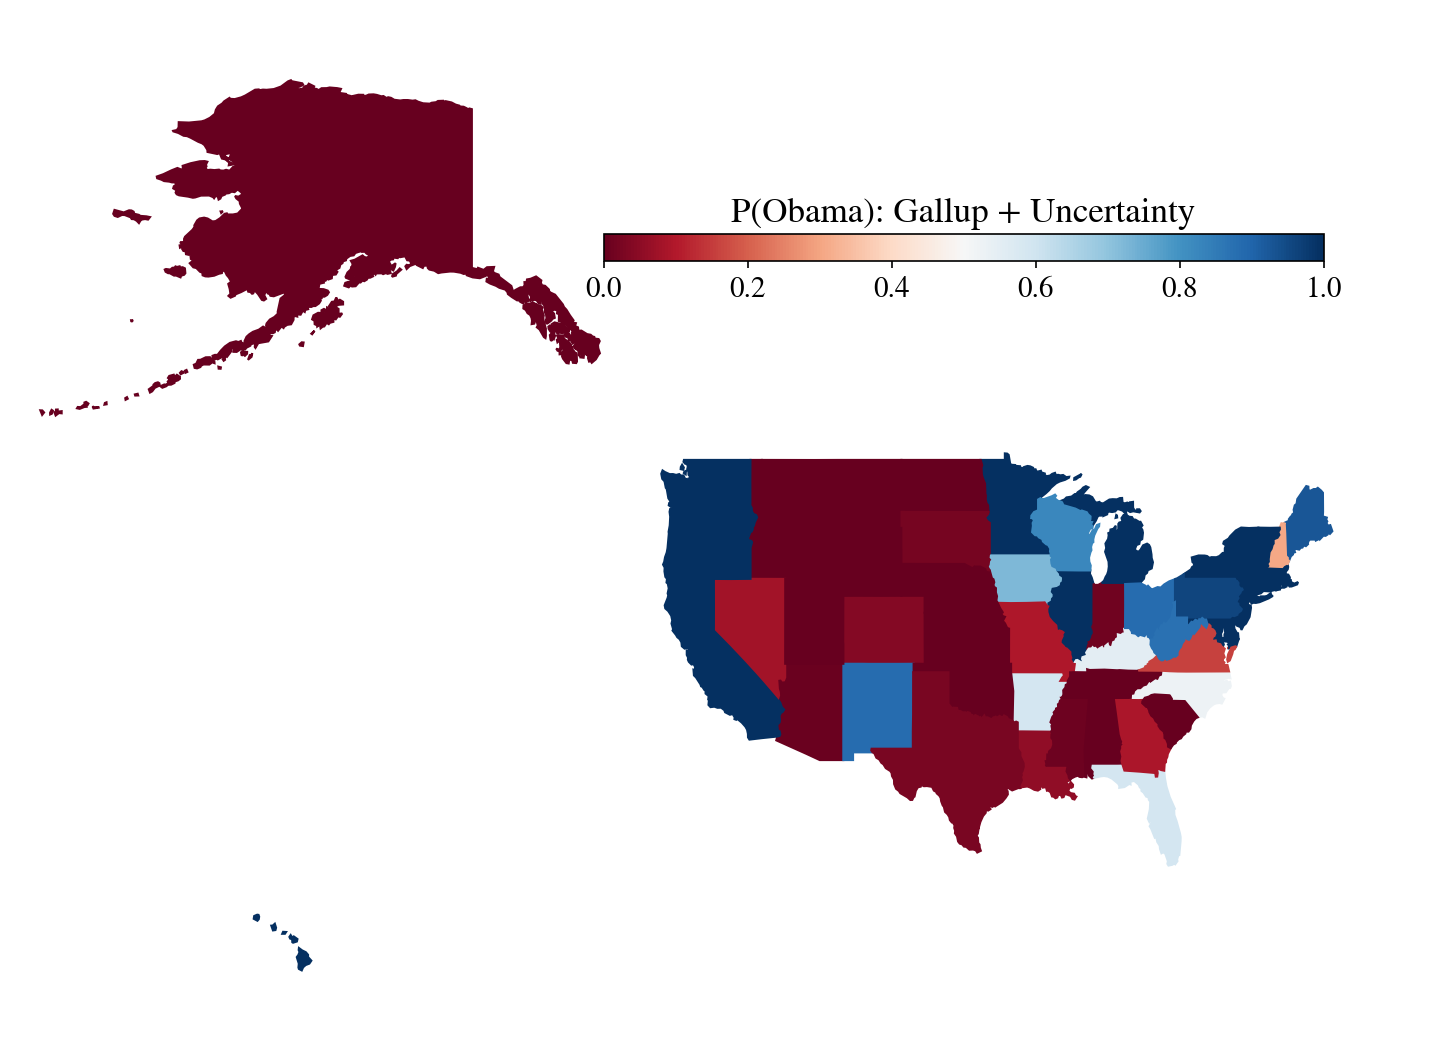

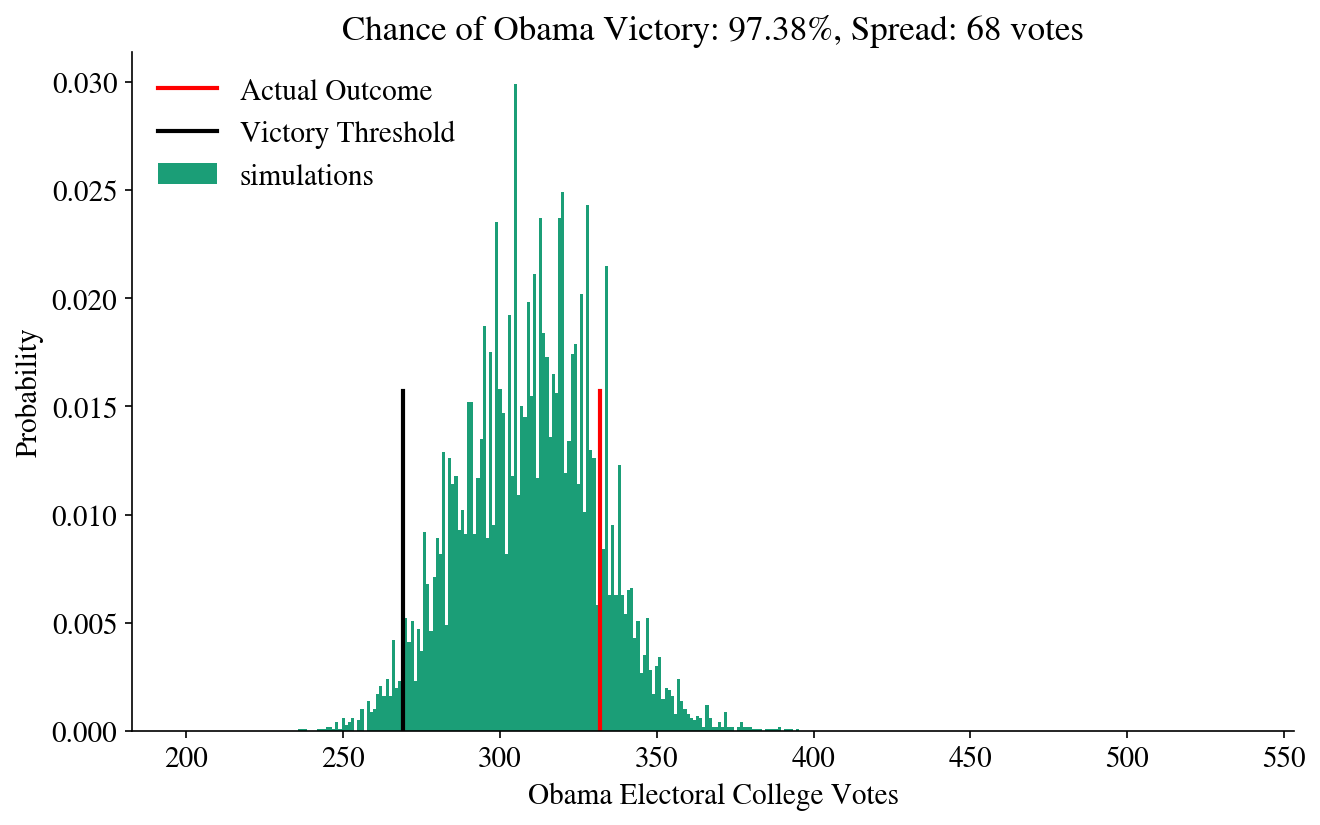

In [23]:
make_map(model.Obama, "P(Obama): Gallup + Uncertainty")
plt.show()
prediction = simulate_election(model, 10000)
plot_simulation(prediction)

**1.9**  *Attempt to **validate** the above model using the histogram. Does the predictive distribution appear to be consistent with the real data? Comment on the accuracy and precision of the prediction.*

The Accuracy and Precision of the model are still extremely high. The model has been better fitted to predict the outcome of the 2012 election. Though it's still an extremely biased and brittle model i would argue. That probably suffers from a high degree of overfitting.

#### Biases

While accounting for uncertainty is one important part of making predictions, we also want to avoid systematic errors. We call systematic over- or under-estimation of an unknown quantity **bias**. In the case of this forecast, our predictions would be biased if the estimates from this poll *systematically* over- or under-estimate vote proportions on election day. There are several reasons this might happen:

1. **Gallup is wrong**. The poll may systematically over- or under-estimate party affiliation. This could happen if the people who answer Gallup phone interviews might not be a representative sample of people who actually vote, Gallup's methodology is flawed, or if people lie during a Gallup poll.
1. **Our assumption about party affiliation is wrong**. Party affiliation may systematically over- or under-estimate vote proportions. This could happen if people identify with one party, but strongly prefer the candidate from the other party, or if undecided voters do not end up splitting evenly between Democrats and Republicans on election day.
1. **Our assumption about equilibrium is wrong**. This poll was released in August, with more than two months left for the elections. If there is a trend in the way people change their affiliations during this time period (for example, because one candidate is much worse at televised debates), an estimate in August could systematically miss the true value in November.

One way to account for bias is to calibrate our model by estimating the bias and adjusting for it. Before we do this, let's explore how sensitive our prediction is to bias.

**1.10** *Implement a `biased_gallup` forecast, which assumes the vote share for the Democrat on election day will be equal to `Dem_Adv` shifted by a fixed negative amount.* We will call this shift the "bias", so a bias of 1% means that the expected vote share on election day is `Dem_Adv`-1.

**Hint**  You can do this by wrapping the `uncertain_gallup_model` in a function that modifies its inputs.

In [24]:
"""
Function
--------
biased_gallup_poll

Subtracts a fixed amount from Dem_Adv, beofore computing the uncertain_gallup_model.
This simulates correcting a hypothetical bias towards Democrats
in the original Gallup data.

Inputs
-------
gallup : DataFrame
    The Gallup party affiliation data frame above
bias : float
    The amount by which to shift each prediction

Examples
--------
>>> model = biased_gallup(gallup, 1.)
>>> model.ix['Flordia']
>>> .460172
"""
#your code here
def biased_gallup(gallup, bias):
    g2 = gallup.copy()
    g2.Dem_Adv -= bias
    return uncertain_gallup_model(g2)


**1.11** *Simulate elections assuming a bias of 1% and 5%, and plot histograms for each one.*

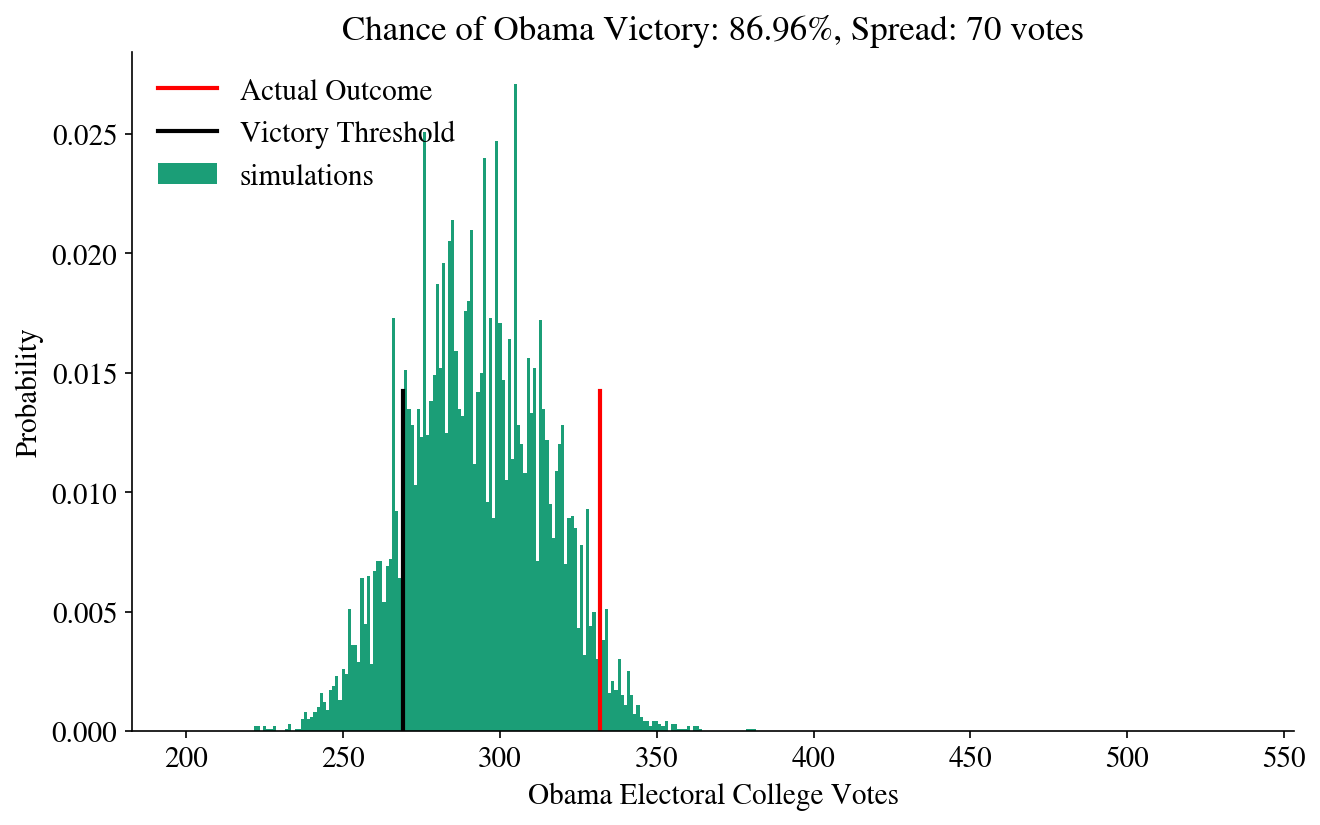

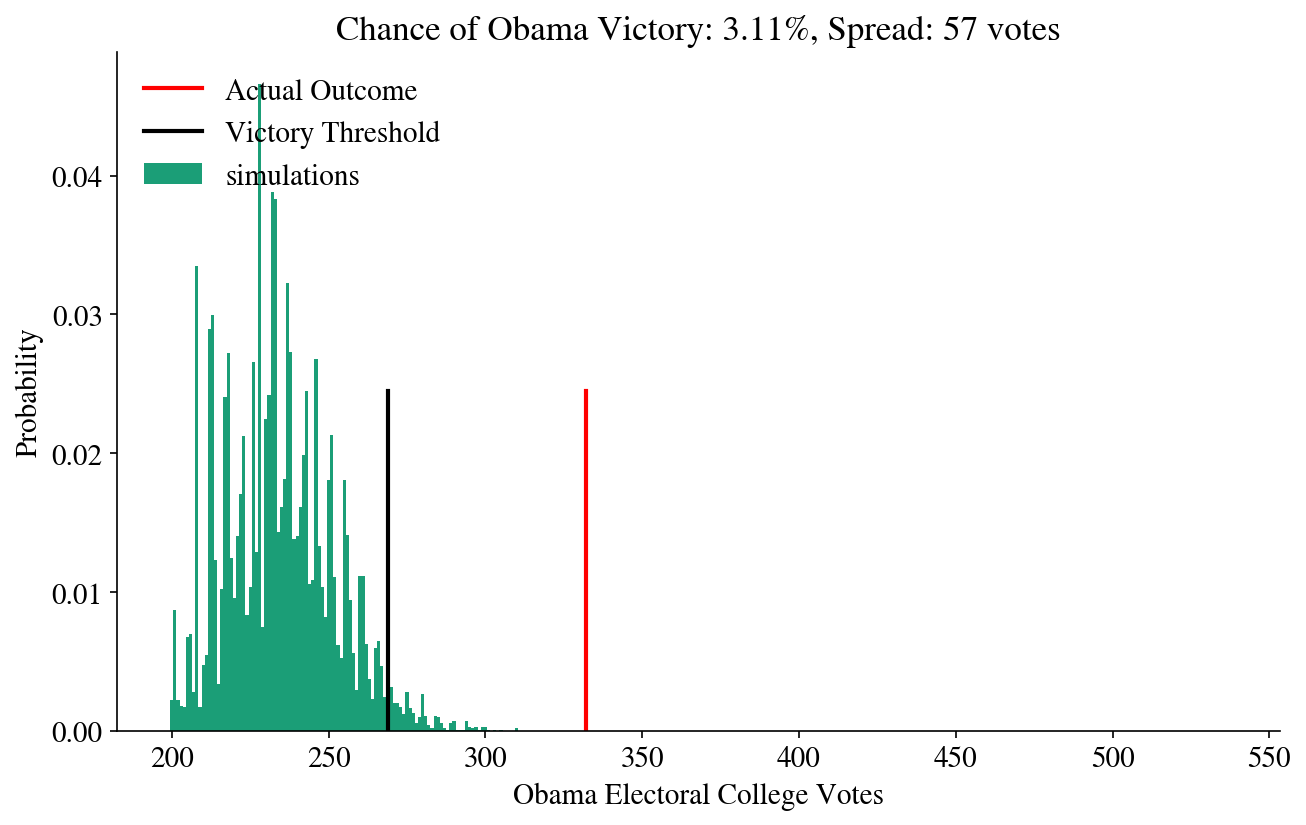

In [25]:
# model with a bias of one percent
model_one = biased_gallup(gallup_2012, 1.)
model_one = model_one.join(electoral_votes)
model_five = biased_gallup(gallup_2012, 5.)
model_five = model_five.join(electoral_votes)
# simulating the elections for both bias models
prediction_one = simulate_election(model_one, 10000)
prediction_five = simulate_election(model_five, 10000)
# plotting the two models election predictions
plot_simulation(prediction_one)
plot_simulation(prediction_five)

Note that even a small bias can have a dramatic effect on the predictions. Pundits made a big fuss about bias during the last election, and for good reason -- it's an important effect, and the models are clearly sensitive to it. Forecastors like Nate Silver would have had an easier time convincing a wide audience about their methodology if bias wasn't an issue.

Furthermore, because of the nature of the electoral college, biases get blown up large. For example, suppose you mis-predict the party Florida elects. We've possibly done this as a nation in the past :-). Thats 29 votes right there. So, the penalty for even one misprediction is high.

#### Estimating the size of the bias from the 2008 election

While bias can lead to serious inaccuracy in our predictions, it is fairly easy to correct *if* we are able to estimate the size of the bias and adjust for it. This is one form of **calibration**.

One approach to calibrating a model is to use historical data to estimate the bias of a prediction model. We can use our same prediction model on historical data and compare our historical predictions to what actually occurred and see if, on average, the predictions missed the truth by a certain amount. Under some assumptions (discussed in a question below), we can use the estimate of the bias to adjust our current forecast.

In this case, we can use data from the 2008 election. (The Gallup data from 2008 are from the whole of 2008, including after the election):

In [26]:
gallup_08 = pd.read_csv("hw2_data/g08.csv").set_index('State')
results_08 = pd.read_csv('hw2_data/2008results.csv').set_index('State')

prediction_08 = gallup_08[['Dem_Adv']]
prediction_08['Dem_Win']=results_08["Obama Pct"] - results_08["McCain Pct"]
prediction_08.head()

/Users/alexanderbaker/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,Dem_Adv,Dem_Win
State,,
Alabama,-0.8,-21.58
Alaska,-10.6,-21.53
Arizona,-0.4,-8.52
Arkansas,12.5,-19.86
California,19.4,24.06


**1.12** *Make a scatter plot using the `prediction_08` dataframe of the democratic advantage in the 2008 Gallup poll (X axis) compared to the democratic win percentage -- the difference between Obama and McCain's vote percentage -- in the election (Y Axis). Overplot a linear fit to these data.*

**Hint**
The `np.polyfit` function can compute linear fits, as can `sklearn.linear_model.LinearModel`

[  1.26390486 -11.32855786]


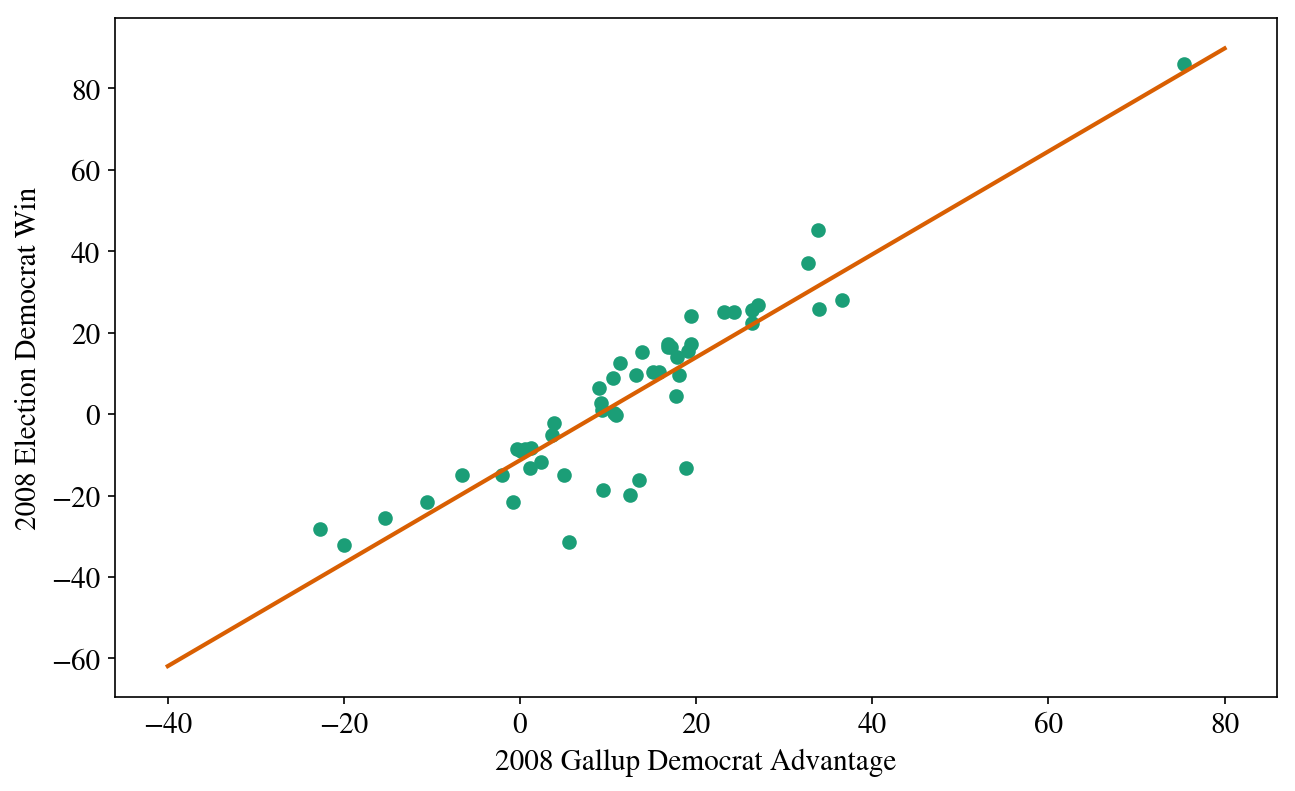

In [27]:
#your code here
plt.plot(prediction_08.Dem_Adv, prediction_08.Dem_Win, 'o')
plt.xlabel("2008 Gallup Democrat Advantage")
plt.ylabel("2008 Election Democrat Win")
fit = np.polyfit(prediction_08.Dem_Adv, prediction_08.Dem_Win, 1)
x = np.linspace(-40, 80, 10)
y = np.polyval(fit, x)
plt.plot(x, y)
print (fit)

Notice that a lot of states in which Gallup reported a Democratic affiliation, the results were strongly in the opposite direction. Why might that be? You can read more about the reasons for this [here](http://www.gallup.com/poll/114016/state-states-political-party-affiliation.aspx#1).

A quick look at the graph will show you a number of states where Gallup showed a Democratic advantage, but where the elections were lost by the democrats. Use Pandas to list these states.

In [28]:
#your code here
prediction_08[(prediction_08.Dem_Adv > 0) & (prediction_08.Dem_Win < 0)]

,Dem_Adv,Dem_Win
State,,
Arkansas,12.5,-19.86
Georgia,3.6,-5.21
Kentucky,13.5,-16.23
Louisiana,9.4,-18.63
Mississippi,1.1,-13.18
Missouri,10.9,-0.14
Montana,3.9,-2.26
North Dakota,0.6,-8.63
Oklahoma,5.6,-31.30


We compute the average difference between the Democrat advantages in the election and Gallup poll

In [30]:
print ((prediction_08.Dem_Adv - prediction_08.Dem_Win).mean())

8.068039215686275


This was a disaster. The 8% calibration completey destroys the accuracy of our prediction in 2012. Our calibration made the assumptions that a) the bias in 2008 was the same as 2012, and b) the bias in each state was the same.

There are several ways in which these assumptions may have been violated. Gallup may have changed their methodology to account for this bias already, leading to a different bias in 2012 from what there was in 2008. The state-by-state biases may have also been different -- voters in highly conservative states may have responded to polls differently from voters in libreral states, for instance. It might have been better to callibrate the bias on a state-wide or clustered basis.


**1.13** * **Calibrate** your forecast of the 2012 election using the estimated bias from 2008. Validate the resulting model against the real 2012 outcome. Did the calibration help or hurt your prediction?*

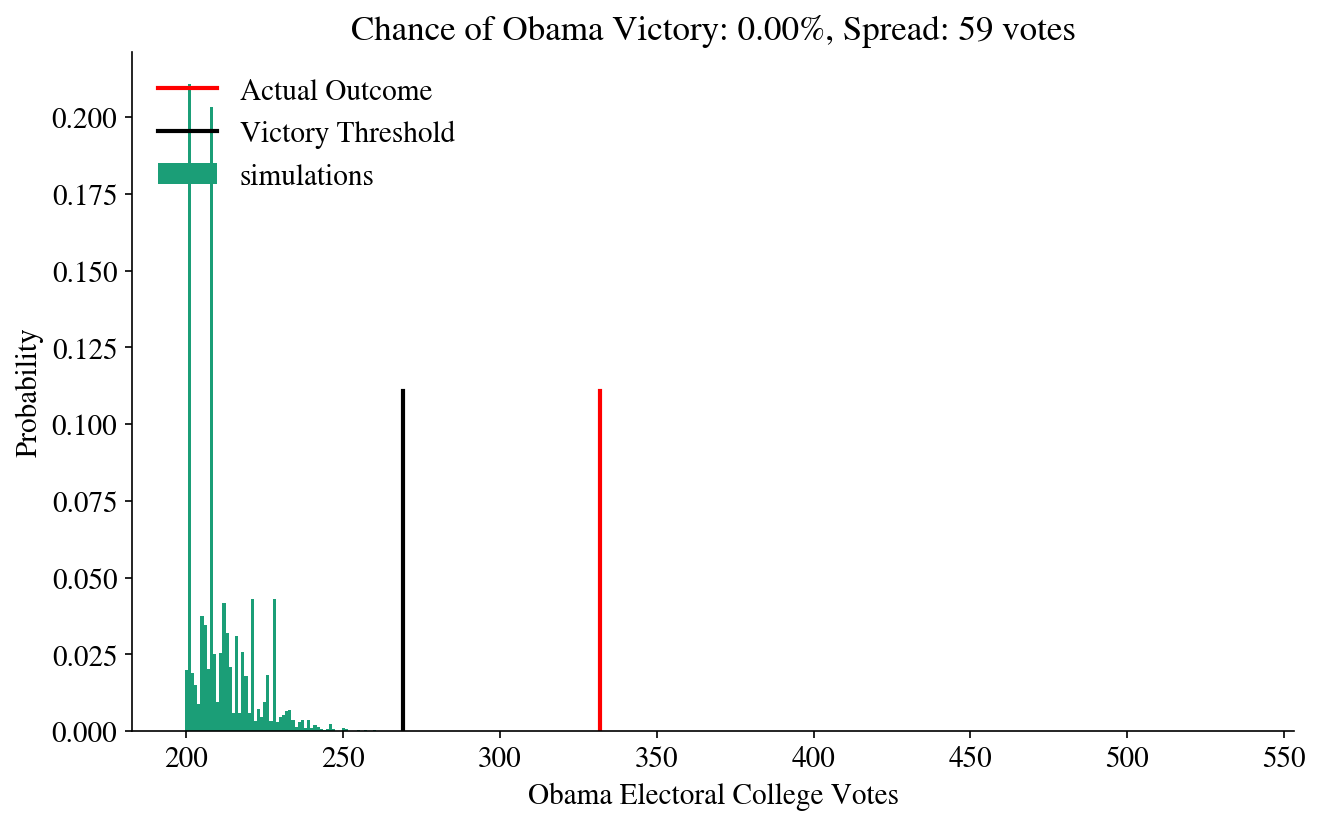

/Users/alexanderbaker/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


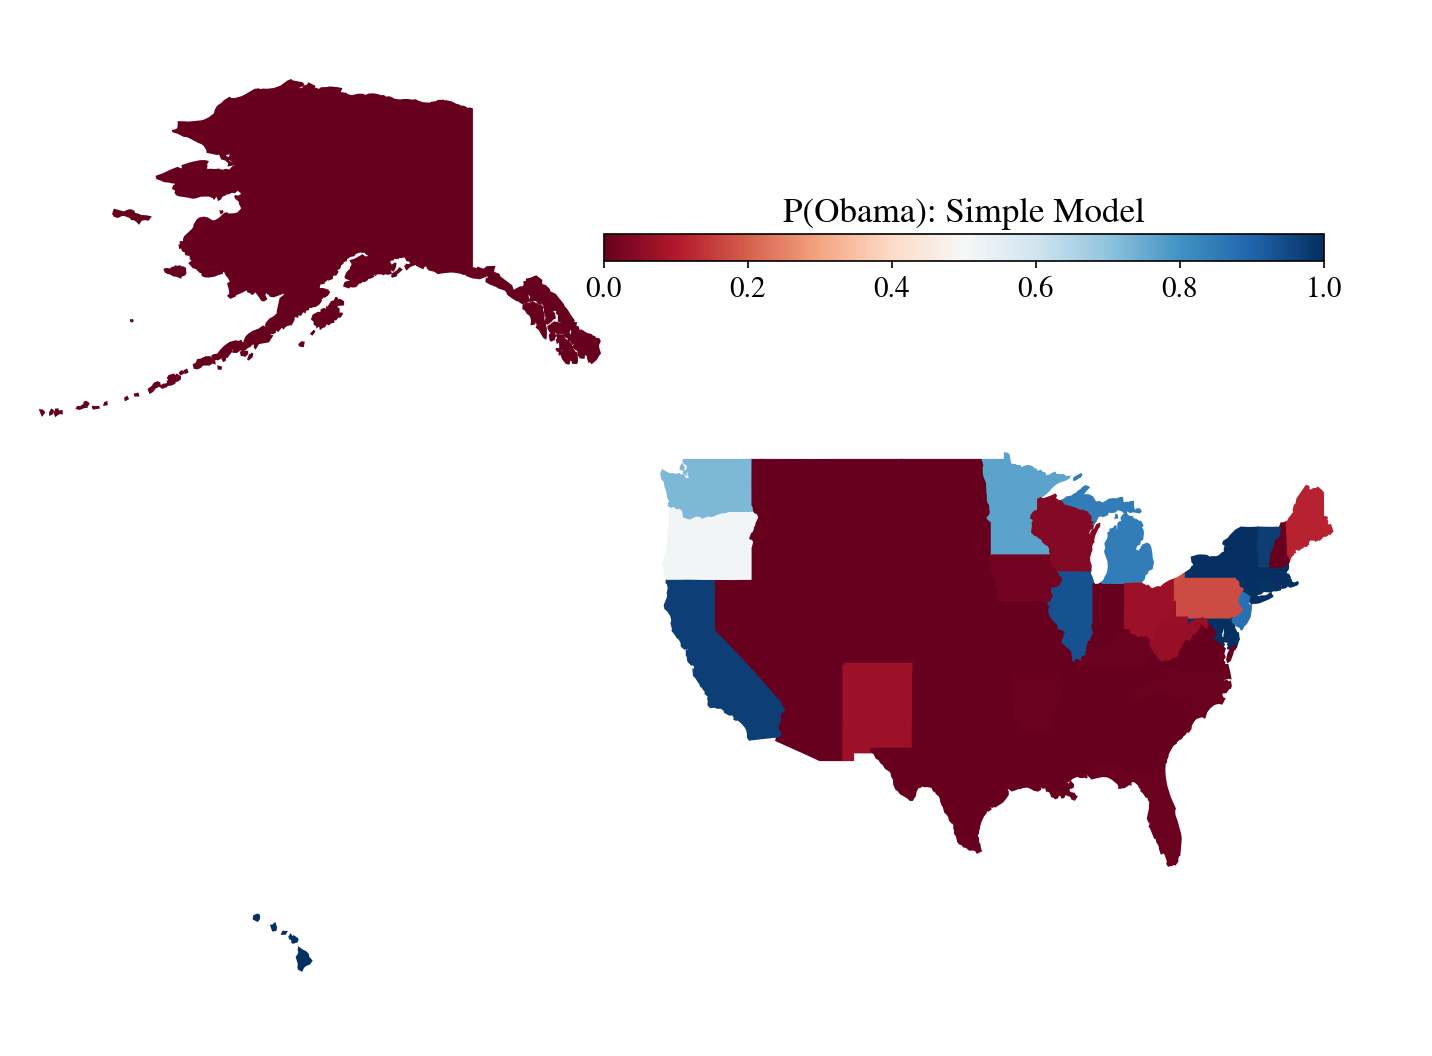

In [31]:
#your code here
model = biased_gallup(gallup_2012, 8.)
model = model.join(electoral_votes)
prediction = simulate_election(model, 10000)

plot_simulation(prediction)
plt.show()
make_map(model.Obama, "P(Obama): Simple Model")

**1.14** *Finally, given that we know the actual outcome of the 2012 race, and what you saw from the 2008 race would you trust the results of the an election forecast based on the 2012 Gallup party affiliation poll?*

*Your answer here*

##Question 2: Logistic Considerations

In the previous forecast, we used the strategy of taking some side-information about an election (the partisan affiliation poll) and relating that to the predicted outcome of the election. We tied these two quantities together using a very simplistic assumption, namely that the vote outcome is deterministically related to estimated partisan affiliation.

In this section, we use a more sophisticated approach to link side information -- usually called **features** or **predictors** -- to our prediction. This approach has several advantages, including the fact that we may use multiple features to perform our predictions. Such data may include demographic data, exit poll data, and data from previous elections.

First, we'll construct a new feature called PVI, and use it and the Gallup poll to build predictions. Then, we'll use **logistic regression** to estimate win probabilities, and use these probabilities to build a prediction.

#### The Partisan Voting Index

The Partisan Voting Index (PVI) is defined as the excessive swing towards a party in the previous election in a given state. In other words:

$$
PVI_{2008} (state) = 
Democratic.Percent_{2004} ( state ) - Republican.Percent_{2004} ( state) - \\ 
                \Big ( Democratic.Percent_{2004} (national) - Republican.Percent_{2004} (national) \Big )
$$

To calculate it, let us first load the national percent results for republicans and democrats in the last 3 elections and convert it to the usual `democratic - republican` format.

In [27]:
national_results=pd.read_csv("data/nat.csv")
national_results.set_index('Year',inplace=True)
national_results.head()

Let us also load in data about the 2004 elections from `p04.csv` which gets the results in the above form for the 2004 election for each state.

In [28]:
polls04=pd.read_csv("data/p04.csv")
polls04.State=polls04.State.replace(states_abbrev)
polls04.set_index("State", inplace=True);
polls04.head()

In [29]:
pvi08=polls04.Dem - polls04.Rep - (national_results.xs(2004)['Dem'] - national_results.xs(2004)['Rep'])
pvi08.head()

**2.1** *Build a new DataFrame called `e2008`.* The dataframe `e2008` must have the following columns:

* a column named pvi with the contents of the partisan vote index `pvi08`
* a column named `Dem_Adv` which has the Democratic advantage from the frame `prediction_08` of the last question **with the mean subtracted out**
* a column named `obama_win` which has a 1 for each state Obama won in 2008, and 0 otherwise
* a column named `Dem_Win` which has the 2008 election Obama percentage  minus McCain percentage, also from the frame  `prediction_08`
* **The DataFrame should be indexed and sorted by State**

In [30]:
#your code here


We construct a similar frame for 2012, obtaining `pvi` using the 2008 Obama win data which we already have. There is no `obama_win` column since, well, our job is to predict it!

In [31]:
pvi12 = e2008.Dem_Win - (national_results.xs(2008)['Dem'] - national_results.xs(2008)['Rep'])
e2012 = pd.DataFrame(dict(pvi=pvi12, Dem_Adv=gallup_2012.Dem_Adv - gallup_2012.Dem_Adv.mean()))
e2012 = e2012.sort_index()
e2012.head()

We load in the actual 2012 results so that we can compare our results to the predictions.

In [32]:
results2012 = pd.read_csv("data/2012results.csv")
results2012.set_index("State", inplace=True)
results2012 = results2012.sort_index()
results2012.head()

#### Exploratory Data Analysis

**2.2** Lets do a little exploratory data analysis. *Plot a scatter plot of the two PVi's against each other. What are your findings? Is the partisan vote index relatively stable from election to election?*

In [33]:
#your code here


*your answer here*

**2.3** Lets do a bit more exploratory data analysis. *Using a scatter plot, plot `Dem_Adv` against `pvi` in both 2008 and 2012. Use colors red and blue depending upon `obama_win` for the 2008 data points.  Plot the 2012 data using gray color. Is there the possibility of making a linear separation (line of separation) between the red and the blue points on the graph?*

In [34]:
#your code here


*your answer here*

#### The Logistic Regression

Logistic regression is a probabilistic model that links observed binary data to a set of features.

Suppose that we have a set of binary (that is, taking the values 0 or 1) observations $Y_1,\cdots,Y_n$, and for each observation $Y_i$ we have a vector of features $X_i$. The logistic regression model assumes that there is some set of **weights**, **coefficients**, or **parameters** $\beta$, one for each feature, so that the data were generated by flipping a weighted coin whose probability of giving a 1 is given by the following equation:

$$
P(Y_i = 1) = \mathrm{logistic}(\sum \beta_i X_i),
$$

where

$$
\mathrm{logistic}(x) = \frac{e^x}{1+e^x}.
$$

When we *fit* a logistic regression model, we determine values for each $\beta$ that allows the model to best fit the *training data* we have observed (the 2008 election). Once we do this, we can use these coefficients to make predictions about data we have not yet observed (the 2012 election).

Sometimes this estimation procedure will overfit the training data yielding predictions that are difficult to generalize to unobserved data. Usually, this occurs when the magnitudes of the components of $\beta$ become too large. To prevent this, we can use a technique called *regularization* to make the procedure prefer parameter vectors that have smaller magnitude. We can adjust the strength of this regularization to reduce the error in our predictions.

We now write some code as technology for doing logistic regression. By the time you start doing this homework, you will have learnt the basics of logistic regression, but not all the mechanisms of cross-validation of data sets. Thus we provide here the code for you to do the logistic regression, and the accompanying cross-validation.

We first build the features from the 2008 data frame, returning `y`, the vector of labels, and `X` the feature-sample matrix where the columns are the features in order from the list `featurelist`, and each row is a data "point".

In [35]:
from sklearn.linear_model import LogisticRegression

def prepare_features(frame2008, featureslist):
    y= frame2008.obama_win.values
    X = frame2008[featureslist].values
    if len(X.shape) == 1:
        X = X.reshape(-1, 1)
    return y, X

We use the above function to get the label vector and feature-sample matrix for feeding to scikit-learn. We then use the usual scikit-learn incantation `fit` to fit a logistic regression model with regularization parameter `C`. The parameter `C` is a hyperparameter of the model, and is used to penalize too high values of the parameter co-efficients in the loss function that is minimized to perform the logistic regression. We build a new dataframe with the usual `Obama` column, that holds the probabilities used to make the prediction. Finally we return a tuple of the dataframe and the classifier instance, in that order.

In [36]:
def fit_logistic(frame2008, frame2012, featureslist, reg=0.0001):
    y, X = prepare_features(frame2008, featureslist)
    clf2 = LogisticRegression(C=reg)
    clf2.fit(X, y)
    X_new = frame2012[featureslist]
    obama_probs = clf2.predict_proba(X_new)[:, 1]
    
    df = pd.DataFrame(index=frame2012.index)
    df['Obama'] = obama_probs
    return df, clf2

We are not done yet. In order to estimate `C`, we perform a grid search over many `C` to find the best `C` that minimizes the loss function. For each point on that grid, we carry out a `n_folds`-fold cross-validation. What does this mean?

Suppose `n_folds=10`. Then we will repeat the fit 10 times, each time randomly choosing 50/10 ~ 5 states out as a test set, and using the remaining 45/46 as the training set. We use the average score on the test set to score each particular choice of `C`, and choose the one with the best performance.

In [37]:
from sklearn.grid_search import GridSearchCV

def cv_optimize(frame2008, featureslist, n_folds=10, num_p=100):
    y, X = prepare_features(frame2008, featureslist)
    clf = LogisticRegression()
    parameters = {"C": np.logspace(-4, 3, num=num_p)}
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(X, y)
    return gs.best_params_, gs.best_score_


Finally we write the function that we use to make our fits. It takes both the 2008 and 2012 frame as arguments, as well as the featurelist, and the number of cross-validation folds to do. It uses the above defined `logistic_score` to find the best-fit `C`, and then uses this value to return the tuple of result dataframe and classifier described above. This is the function you will be using.

In [38]:
def cv_and_fit(frame2008, frame2012, featureslist, n_folds=5):
    bp, bs = cv_optimize(frame2008, featureslist, n_folds=n_folds)
    predict, clf = fit_logistic(frame2008, frame2012, featureslist, reg=bp['C'])
    return predict, clf

**2.4** *Carry out a logistic fit using the `cv_and_fit` function developed above. As your featurelist use the features we have: `Dem_Adv` and `pvi`.

In [39]:
#your code here


**2.5** *As before, plot a histogram and map of the simulation results, and interpret the results in terms of accuracy and precision.*

In [40]:
#code to make the histogram
#your code here


In [41]:
#code to make the map
#your code here


*your answer here*

#### Classifier Decision boundary

One nice way to visualize a 2-dimensional logistic regression is to plot the probability as a function of each dimension. This shows the **decision boundary** -- the set of parameter values where the logistic fit yields P=0.5, and shifts between a preference for Obama or McCain/Romney.

The function below draws such a figure (it is adapted from the scikit-learn website), and overplots the data.

In [1]:
from matplotlib.colors import ListedColormap
def points_plot(e2008, e2012, clf):
    """
    e2008: The e2008 data
    e2012: The e2012 data
    clf: classifier
    """
    Xtrain = e2008[['Dem_Adv', 'pvi']].values
    Xtest = e2012[['Dem_Adv', 'pvi']].values
    ytrain = e2008['obama_win'].values == 1
    
    X=np.concatenate((Xtrain, Xtest))
    
    # evenly sampled points
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 50),
                         np.linspace(y_min, y_max, 50))
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    #plot background colors
    ax = plt.gca()
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    cs = ax.contourf(xx, yy, Z, cmap='RdBu', alpha=.5)
    cs2 = ax.contour(xx, yy, Z, cmap='RdBu', alpha=.5)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14)
    
    # Plot the 2008 points
    ax.plot(Xtrain[ytrain == 0, 0], Xtrain[ytrain == 0, 1], 'ro', label='2008 McCain')
    ax.plot(Xtrain[ytrain == 1, 0], Xtrain[ytrain == 1, 1], 'bo', label='2008 Obama')
        
    # and the 2012 points
    ax.scatter(Xtest[:, 0], Xtest[:, 1], c='k', marker="s", s=50, facecolors="k", alpha=.5, label='2012')
    plt.legend(loc='upper left', scatterpoints=1, numpoints=1)

    return ax

**2.6** *Plot your results on the classification space boundary plot. How sharp is the classification boundary, and how does this translate into accuracy and precision of the results?*

In [43]:
#your code here


*your answer here*

## Question 3: Trying to catch Silver: Poll Aggregation

In the previous section, we tried to use heterogeneous side-information to build predictions of the election outcome. In this section, we switch gears to bringing together homogeneous information about the election, by aggregating different polling result together.

This approach -- used by the professional poll analysists -- involves combining many polls about the election itself. One advantage of this approach is that it addresses the problem of bias in individual polls, a problem we found difficult to deal with in problem 1. If we assume that the polls are all attempting to estimate the same quantity, any individual biases should cancel out when averaging many polls (pollsters also try to correct for known biases). This is often a better assumption than assuming constant bias between election cycles, as we did above.

The following table aggregates many of the pre-election polls available as of October 2, 2012. We are most interested in the column "obama_spread". We will clean the data for you:

In [44]:
multipoll = pd.read_csv('data/cleaned-state_data2012.csv', index_col=0)

#convert state abbreviation to full name
multipoll.State.replace(states_abbrev, inplace=True)

#convert dates from strings to date objects, and compute midpoint
multipoll.start_date = multipoll.start_date.apply(pd.datetools.parse)
multipoll.end_date = multipoll.end_date.apply(pd.datetools.parse)
multipoll['poll_date'] = multipoll.start_date + (multipoll.end_date - multipoll.start_date).values / 2

#compute the poll age relative to Oct 2, in days
multipoll['age_days'] = (today - multipoll['poll_date']).values / np.timedelta64(1, 'D')

#drop any rows with data from after oct 2
multipoll = multipoll[multipoll.age_days > 0]

#drop unneeded columns
multipoll = multipoll.drop(['Date', 'start_date', 'end_date', 'Spread'], axis=1)

#add electoral vote counts
multipoll = multipoll.join(electoral_votes, on='State')

#drop rows with missing data
multipoll.dropna()

multipoll.head()

**3.1** Using this data, compute a new data frame that averages the obama_spread for each state. Also compute the standard deviation of the obama_spread in each state, and the number of polls for each state.

*Define a function `state_average` which returns this dataframe*

**Hint**

[pd.GroupBy](http://pandas.pydata.org/pandas-docs/dev/groupby.html) could come in handy

In [45]:
"""
Function
--------
state_average

Inputs
------
multipoll : DataFrame
   The multipoll data above
   
Returns
-------
averages : DataFrame
  A dataframe, indexed by State, with the following columns:
     N: Number of polls averaged together
     poll_mean: The average value for obama_spread for all polls in this state
     poll_std: The standard deviation of obama_spread
     
Notes
-----
For states where poll_std isn't finite (because N is too small), estimate the
poll_std value as .05 * poll_mean
"""
#your code here


Lets call the function on the `multipoll` data frame, and join it with the `electoral_votes` frame.

In [46]:
avg = state_average(multipoll).join(electoral_votes, how='outer')
avg.head()

Some of the reddest and bluest states are not present in this data (people don't bother polling there as much). The `default_missing` function gives them strong Democratic/Republican advantages

In [47]:
def default_missing(results):
    red_states = ["Alabama", "Alaska", "Arkansas", "Idaho", "Wyoming"]
    blue_states = ["Delaware", "District of Columbia", "Hawaii"]
    results.ix[red_states, ["poll_mean"]] = -100.0
    results.ix[red_states, ["poll_std"]] = 0.1
    results.ix[blue_states, ["poll_mean"]] = 100.0
    results.ix[blue_states, ["poll_std"]] = 0.1
default_missing(avg)
avg.head()

#### Unweighted aggregation

**3.2** *Build an `aggregated_poll_model` function that takes the `avg` DataFrame as input, and returns a forecast DataFrame*
in the format you've been using to simulate elections. Assume that the probability that Obama wins a state
is given by the probability that a draw from a Gaussian with $\mu=$poll_mean and $\sigma=$poll_std is positive.

In [48]:
"""
Function
--------
aggregated_poll_model

Inputs
------
polls : DataFrame
   DataFrame indexed by State, with the following columns:
      poll_mean
      poll_std
      Votes

Returns
-------
A DataFrame indexed by State, with the following columns:
   Votes: Electoral votes for that state
   Obama: Estimated probability that Obama wins the state
"""
#your code here


**3.3** *Run 10,000 simulations with this model, and plot the results. Describe the results in a paragraph -- compare the methodology and the simulation outcome to the Gallup poll. Also plot the usual map of the probabilities*

In [49]:
#your code here


*Your summary here*

In [50]:
#your code here


#### Weighted Aggregation

Not all polls are equally valuable. A poll with a larger margin of error should not influence a forecast as heavily. Likewise, a poll further in the past is a less valuable indicator of current (or future) public opinion. For this reason, polls are often weighted when building forecasts. 

A weighted estimate of Obama's advantage in a given state is given by

$$
\mu = \frac{\sum w_i \times \mu_i}{\sum w_i}
$$

where $\mu_i$ are individual polling measurements or a state, and $w_i$ are the weights assigned to each poll. The uncertainty on the weighted mean, assuming each measurement is independent, is given by

The estimate of the variance of $\mu$, when $\mu_i$ are unbiased estimators of $\mu$, is

$$\textrm{Var}(\mu) = \frac{1}{(\sum_i w_i)^2} \sum_{i=1}^n w_i^2 \textrm{Var}(\mu_i).$$

#### Whats the matter with Kansas?

We need to find an estimator of the variance of $\mu_i$, $Var(\mu_i)$. In the case of states that have a lot of polls, we expect the bias in $\mu$ to be negligible, and then the above formula for the variance of $\mu$ holds. However, lets take a look at the case of Kansas.

In [51]:
multipoll[multipoll.State=="Kansas"]

There are only two polls in the last year! And, the results in the two polls are far, very far from the mean.

Now, Kansas is a safely Republican state, so this dosent really matter, but if it were a swing state, we'd be in a pickle. We'd have no unbiased estimator of the variance in Kansas. So, to be conservative, and play it safe, we follow the same tack we did with the unweighted averaging of polls, and simply assume that the variance in a state is the square of the standard deviation of `obama_spread`.

This will overestimate the errors for a lot of states, but unless we do a detailed state-by-state analysis, its better to be conservative. Thus, we use:

$\textrm{Var}(\mu)$ = `obama_spread.std()`$^2$ .


The weights $w_i$ should combine the uncertainties from the margin of error and the age of the forecast. One such combination is:

$$
w_i = \frac1{MoE^2} \times \lambda_{\rm age}
$$

where

$$
\lambda_{\rm age} = 0.5^{\frac{{\rm age}}{30 ~{\rm days}}}
$$

This model makes a few ad-hoc assumptions:

1. The equation for $\sigma$ assumes that every measurement is independent. This is not true in the case that a given pollster in a state makes multiple polls, perhaps with some of the same respondents (a longitudinal survey). But its a good assumption to start with.
1. The equation for $\lambda_{\rm age}$ assumes that a 30-day old poll is half as valuable as a current one

**3.4** Nevertheless, it's worth exploring how these assumptions affect the forecast model. *Implement the model in the function `weighted_state_average`*

In [52]:
"""
Function
--------
weighted_state_average

Inputs
------
multipoll : DataFrame
   The multipoll data above
   
Returns
-------
averages : DataFrame
  A dataframe, indexed by State, with the following columns:
     N: Number of polls averaged together
     poll_mean: The average value for obama_spread for all polls in this state
     poll_std: The standard deviation of obama_spread
     
Notes
-----
For states where poll_std isn't finite (because N is too small), estimate the
poll_std value as .05 * poll_mean
"""

#your code here


**3.5** *Put this all together -- compute a new estimate of `poll_mean` and `poll_std` for each state, apply the `default_missing` function to handle missing rows, build a forecast with `aggregated_poll_model`, run 10,000 simulations, and plot the results, both as a histogram and as a map.*

In [53]:
#your code here


In [54]:
#your map code here
make_map(model.Obama, "P(Obama): Weighted Polls")

**3.6** *Discuss your results in terms of bias, accuracy and precision, as before*

*your answer here*

For fun, but not to hand in, play around with turning off the time decay weight and the sample error weight individually.

#### Parting Thoughts: What do the pros do?

The models we have explored in this homework have been fairly ad-hoc. Still, we have seen predicting by simulation, prediction using heterogeneous side-features, and finally by weighting polls that are made in the election season. The pros pretty much start from poll-averaging, adding in demographics and economic information, and moving onto trend-estimation as the election gets closer. They also employ models of likely voters vs registered voters, and how independents might break. At this point, you are prepared to go and read more about these techniques, so let us leave you with some links to read:

1. Skipper Seabold's reconstruction of parts of Nate Silver's model: https://github.com/jseabold/538model . We've drawn direct inspiration from his work , and indeed have used some of the data he provides in his repository

2. The simulation techniques are partially drawn from Sam Wang's work at http://election.princeton.edu . Be sure to check out the FAQ, Methods section, and matlab code on his site.

3. Nate Silver, who we are still desperately seeking, has written a lot about his techniques: http://www.fivethirtyeight.com/2008/03/frequently-asked-questions-last-revised.html . Start there and look around

4. Drew Linzer uses bayesian techniques, check out his work at: http://votamatic.org/evaluating-the-forecasting-model/

How to submit

To submit your homework, create a folder named lastname_firstinitial_hw2 and place this notebook file in the folder. Also put the data folder in this folder. **Make sure everything still works!** Select Kernel->Restart Kernel to restart Python, Cell->Run All to run all cells. You shouldn't hit any errors. Compress the folder (please use .zip compression) and submit to the CS109 dropbox in the appropriate folder. If we cannot access your work because these directions are not followed correctly, we will not grade your work.

---
*css tweaks in this cell*
<style>
div.text_cell_render {
    line-height: 150%;
    font-size: 110%;
    width: 850px;
    margin-left:50px;
    margin-right:auto;
    }
</style>